In [127]:
import pandas as pd

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench201'

In [128]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [160]:
dataset = 'ImageNet16-120'
data = dfs[dataset]

In [161]:
import json
with open('meta.json', 'r') as f:
    meta = json.load(f)
nb201_unique = [v['nb201-string'] for k, v in meta['ids'].items() if k == v['isomorph']]
nb201_unique[0]

'|avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|'

In [162]:
from naslib.search_spaces.nasbench201.conversions import convert_str_to_op_indices

unique_nets = {str(convert_str_to_op_indices(nu)) for nu in nb201_unique}

In [163]:
data = data[data['net'].isin(unique_nets)]

In [164]:
from zc_combine.fixes.operations import get_ops_edges_nb201
from zc_combine.fixes.utils import nb201_default_isomorphic_cell

_, edge_map = get_ops_edges_nb201()
nb201_default_isomorphic_cell(data, edge_map)

/home/gabi/.env/lib/python3.8/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/gabi/.env/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [165]:
print(len(data))
data = data[data['net'] == data['new_net']]
print(len(data))

6466
6144


In [166]:
from zc_combine.features.conversions import nb201_to_graph

nets = {i: nb201_to_graph(data.loc[i]) for i in data.index}

In [167]:
from zc_combine.features.counts import count_ops

op_counts = [{'idx': i, **count_ops(o, e)} for i, (o, e) in nets.items()]

In [168]:
import pandas as pd

opdf = pd.DataFrame(op_counts)
opdf.set_index('idx', inplace=True)
opdf['val_accs'] = data['val_accs']
opdf

,0,1,2,3,4,val_accs
idx,,,,,,
0,1,1,0,2,2,32.700000
1,2,0,2,1,1,44.233333
3,2,1,2,1,0,40.600000
7,0,1,0,4,1,37.100000
8,0,1,2,3,0,42.200000
...,...,...,...,...,...,...
15617,1,1,2,1,1,40.400000
15618,2,0,2,1,1,39.300000
15620,1,1,1,1,2,36.433333


In [169]:
from zc_combine.features.counts import min_path_len

path_df = []
for i, net in nets.items():
    res = {'idx': i}
    for banned in [(1,), (0, 1), (0, 1, 4), (1, 4)]:
        res[str(banned)] = min_path_len(net[1], banned)

    path_df.append(res)
path_df = pd.DataFrame(path_df).set_index('idx')
path_df['val_accs'] = data['val_accs']
path_df

,"(1,)","(0, 1)","(0, 1, 4)","(1, 4)",val_accs
idx,,,,,
0,1,1,1,1,32.700000
1,1,2,2,1,44.233333
3,1,1,1,1,40.600000
7,1,1,1,1,37.100000
8,1,1,1,1,42.200000
...,...,...,...,...,...
15617,1,1,2,2,40.400000
15618,1,1,1,1,39.300000
15620,2,2,5,2,36.433333


In [170]:
from zc_combine.features.counts import max_num_on_path

edge_path_df = []
for i, net in nets.items():
    res = {'idx': i}
    for allowed in [(0,), (0, 2), (0, 2, 3), (0, 3), (2, 3), (2,), (3,)]:
        res[str(allowed)] = max_num_on_path(net[1], allowed)

    edge_path_df.append(res)

edge_path_df = pd.DataFrame(edge_path_df).set_index('idx')
edge_path_df['val_accs'] = data['val_accs']
edge_path_df

,"(0,)","(0, 2)","(0, 2, 3)","(0, 3)","(2, 3)","(2,)","(3,)",val_accs
idx,,,,,,,,
0,0,0,1,1,1,0,1,32.700000
1,1,1,1,1,2,0,0,44.233333
3,0,1,1,2,1,1,0,40.600000
7,0,0,1,1,1,0,1,37.100000
8,0,1,1,3,1,1,3,42.200000
...,...,...,...,...,...,...,...,...
15617,0,3,2,0,2,0,0,40.400000
15618,0,1,1,2,1,1,0,39.300000
15620,0,2,2,0,0,0,0,36.433333


In [171]:
from zc_combine.features.counts import op_on_pos

opos_df = []
for i, net in nets.items():
    res = {'idx': i}

    res.update(op_on_pos(*net))
    opos_df.append(res)

opos_df = pd.DataFrame(opos_df).set_index('idx')
opos_df['val_accs'] = data['val_accs']
opos_df

,"(0, (1, 2))","(0, (1, 3))","(0, (1, 4))","(0, (2, 3))","(0, (2, 4))","(0, (3, 4))","(1, (1, 2))","(1, (1, 3))","(1, (1, 4))","(1, (2, 3))",...,"(3, (2, 3))","(3, (2, 4))","(3, (3, 4))","(4, (1, 2))","(4, (1, 3))","(4, (1, 4))","(4, (2, 3))","(4, (2, 4))","(4, (3, 4))",val_accs
idx,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,1,0,32.700000
1,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,44.233333
3,1,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,40.600000
7,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,0,0,0,0,0,37.100000
8,0,0,0,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,42.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15617,0,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,0,40.400000
15618,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,39.300000
15620,0,0,0,0,0,1,0,0,1,0,...,0,1,0,1,0,0,1,0,0,36.433333


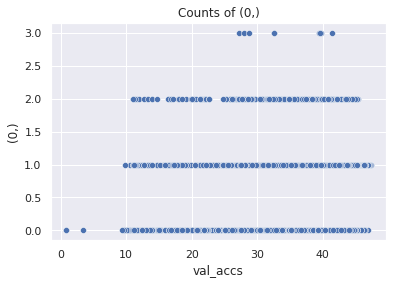

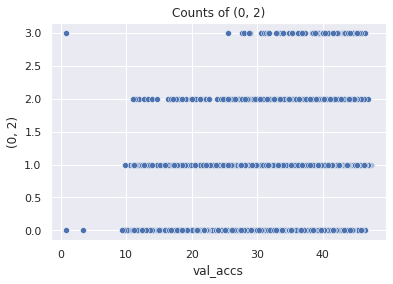

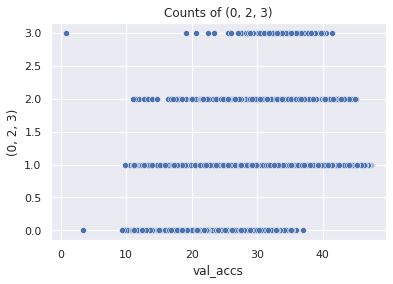

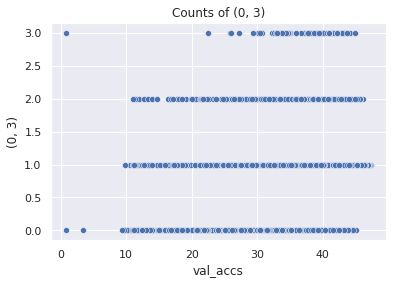

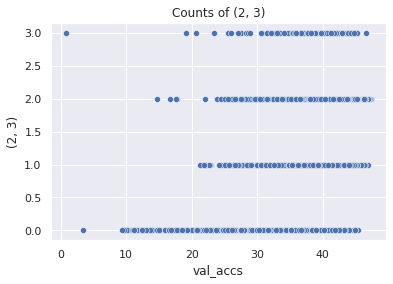

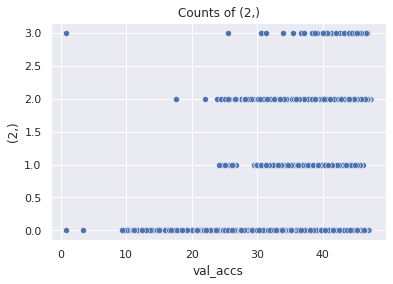

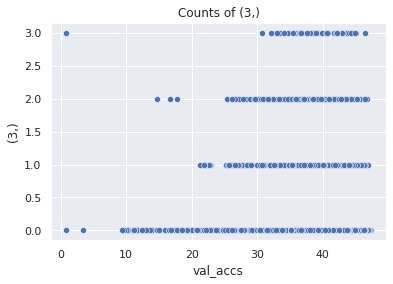

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_df = edge_path_df

import os
#os.mkdir('tmp')

for c in plot_df.columns:
    if c == 'val_accs':
        continue
    plt.figure()
    sns.scatterplot(data=plot_df, x='val_accs', y=c)
    plt.title(f"Counts of {c}")
    #plt.savefig(f'tmp/{c}.png')
    plt.show()

In [173]:
edges = list(edge_map.keys())

dataset_raw = {i: [n[1][e] for e in edges] for i, n in nets.items()}
dataset_raw[0]

[4, 0, 3, 1, 4, 3]

In [174]:
draw = [{'idx': i, **{f'op_{j}': v for j, v in enumerate(o)}} for i, o in dataset_raw.items()]
draw = pd.DataFrame(draw).set_index('idx')

In [249]:
proxy_cols = [c for c in data.columns if c not in ['random', 'rank', 'new_net', 'net']]


def get_dataset(features, cols):
    if not len(features):
        dataset = data[cols].copy()
    else:
        dataset = pd.concat([*features, data[cols]], axis=1)

    y = dataset['val_accs']
    y = y.iloc[:, 0].copy() if hasattr(y, 'columns') else y
    dataset.drop(columns=['val_accs'], inplace=True)
    return dataset, y

dataset, y = get_dataset([draw, opdf, edge_path_df], ['val_accs', 'flops', 'params'])
print(dataset.shape)

(6144, 50)


In [250]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

def eval_rf(data, y, random_state=43, train_size=100, return_data=False):
    train_X, test_X, train_y, test_y = train_test_split(data, y, random_state=random_state, train_size=train_size)

    rf = RandomForestRegressor(n_estimators=100)
    rf.fit(train_X, train_y)
    score = rf.score(test_X, test_y)

    preds = rf.predict(data)
    print("Kendall: ", kendalltau(preds, y)[0], ", Corr: ", spearmanr(preds, y)[0])

    return (rf, score) if not return_data else (rf, score, train_X, test_X, train_y, test_y)

In [256]:
for ts in [100, 200, 1000]:
    print(f"Train size {ts}")
    for prox in proxy_cols:
        if prox in ['flops', 'params']:
            continue
        print(prox)

        dd, dy = get_dataset([draw, opdf, edge_path_df], ['val_accs', 'flops', 'params',  prox])
        _, sc = eval_rf(dd.to_numpy(), dy.to_numpy(), train_size=ts)
        print(sc)
        print()

Train size 100
val_accs
Kendall:  0.6806463224233429 , Corr:  0.85344454753899
0.7665278456920335

epe_nas
Kendall:  0.6774224306248976 , Corr:  0.855093821953992
0.7465256199747867

fisher
Kendall:  0.7214544264823863 , Corr:  0.8906692063026006
0.7942492997622949

grad_norm
Kendall:  0.7154548182520537 , Corr:  0.8834731053379817
0.7868075708258458

grasp
Kendall:  0.7052707037302077 , Corr:  0.8761054712517662
0.7866020060312768

jacov
Kendall:  0.7139444614954154 , Corr:  0.8816256266956548
0.803300300850061

l2_norm
Kendall:  0.6610107333475913 , Corr:  0.8394169430079872
0.7330557875115137

nwot
Kendall:  0.6886624044063306 , Corr:  0.8659927989248156
0.7377612431221315

plain
Kendall:  0.6795542512813604 , Corr:  0.8543150726427567
0.7554059695556217

snip
Kendall:  0.7081249902135862 , Corr:  0.8756820094888077
0.7851212936160546

synflow
Kendall:  0.6688378792599962 , Corr:  0.8457245649757233
0.7336668148861847

zen
Kendall:  0.691341073471011 , Corr:  0.8618554453442205
0.77

In [318]:
#ds, dsy = get_dataset([], proxy_cols)
#ds, dsy = get_dataset([draw, opdf, path_df, edge_path_df], proxy_cols)
ds, dsy = get_dataset([draw, opdf, path_df, edge_path_df], ['val_accs', 'params', 'flops'])
rf_fitted, s, trx, tex, ty, te = eval_rf(ds.to_numpy(), dsy.to_numpy(), return_data=True, train_size=100)
print(s)
preds = rf_fitted.predict(ds.to_numpy())
preds

Kendall:  0.69048807016375 , Corr:  0.8641053277382632
0.7600506506913505


array([34.4933333 , 42.97166667, 43.46766659, ..., 36.24933321,
       40.55699995, 34.54699996])

In [319]:
trainpreds = rf_fitted.predict(trx)

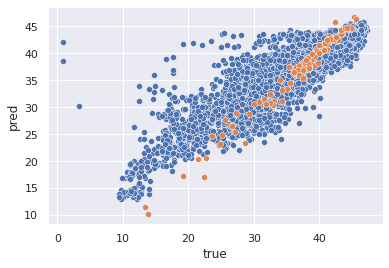

In [320]:
sns.scatterplot(data=pd.DataFrame({'pred': preds, 'true': y}), x='true', y='pred')
sns.scatterplot(data=pd.DataFrame({'pred': trainpreds, 'true': ty}), x='pred', y='true')
#plt.ylim(70, 95)
plt.show()

In [293]:
imps = rf_fitted.feature_importances_

pd.DataFrame({"importance": imps, "feat": ds.columns})

,importance,feat
0,0.014304,epe_nas
1,0.014447,fisher
2,0.006752,flops
3,0.011416,grad_norm
4,0.016794,grasp
5,0.151959,jacov
6,0.055876,l2_norm
7,0.629945,nwot
8,0.011317,params
9,0.008753,plain


In [289]:
pd.DataFrame({'pred': preds, 'true': y, 'net': data['net']})

,pred,true,net
0,36.598667,32.700000,"(4, 0, 3, 1, 4, 3)"
1,43.192333,44.233333,"(2, 4, 0, 0, 3, 2)"
3,42.584000,40.600000,"(0, 0, 2, 1, 2, 3)"
7,37.568667,37.100000,"(4, 1, 3, 3, 3, 3)"
8,38.849333,42.200000,"(3, 1, 2, 3, 2, 3)"
...,...,...,...
15617,42.149000,40.400000,"(2, 1, 4, 2, 3, 0)"
15618,39.593667,39.300000,"(3, 2, 2, 4, 0, 0)"
15620,36.442000,36.433333,"(4, 2, 1, 4, 3, 0)"
15622,41.925333,44.066667,"(2, 3, 3, 3, 2, 4)"


In [282]:
from scipy.stats import kendalltau, spearmanr

kendalltau(preds, dsy)[0], spearmanr(preds, dsy)[0]

(0.6939325167447508, 0.8681800702988072)

In [244]:
tex

array([[ 2.      ,  3.      ,  4.      , ...,  0.      ,  0.837576,
        30.271552],
       [ 2.      ,  2.      ,  4.      , ...,  0.      ,  0.594536,
        21.639232],
       [ 2.      ,  3.      ,  0.      , ...,  0.      ,  0.379496,
        13.452352],
       ...,
       [ 2.      ,  3.      ,  1.      , ...,  0.      ,  0.594536,
        21.639232],
       [ 2.      ,  1.      ,  4.      , ...,  0.      ,  0.379496,
        13.452352],
       [ 2.      ,  1.      ,  1.      , ...,  0.      ,  0.809576,
        29.180992]])

In [757]:
# TODO ruzny pocty siti
# where to sample... important
# TODO predikovat pres proxyny

# TODO vyplot predikci jen pres flops/params
# ... try that on transnb101

In [ ]:
#Next steps:

# TODO lepsi nazvy sloupecku, to str
# TODO fce co to spocita a da do df (myslim ty edge_path_op atd)
# TODO predikce - pres ruzny seedy, mozna crossval
# TODO porovnani s proxynama a bez, xgboost,...
# TODO tnb101

# TODO ruzny dalsi features...